# Bayesian Financial Forecasting

The goal in quantitative finance is to forecast the price movement across a breadth of
assets, which is hard because of the efficient market hypothesis.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import numpy as np
import six
import tensorflow as tf

from edward.inferences import VariationalInference
from edward.models import Bernoulli, Normal, RandomVariable
from edward.util import copy
from scipy.special import expit
from sklearn.metrics import log_loss

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


ed.set_seed(42)

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import pylab
pylab.rcParams['figure.figsize'] = (16.0, 10.0)

# use custom helper functions from src folder
import sys
sys.path.insert(0, '../src/')

from data import *
from inference import *
from helpers import *
from model_zoo import conv_lstm 

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


### DATA

To forecast asset excess price movements, we'll will analyze a truncated version of a preprocessed and
handcrafted dataset $X$ (aligned dimensions: 50 x 25000) that according to experts in the field
holds higher candidacy for predictive power.

Our target $y$ being 1 (when price movement is Up) or 0 (Down). The target data is balanced.

In [2]:
from dataset import DataSet

pca_comps = range(0,50)
dataset = DataSet(pca_comps=pca_comps, frac=1)
X_data, y_data, X_test, y_test = dataset.get_train_and_val()
print('shapes (X_data,y_data),', X_data.shape, y_data.shape)
print('dataset is balanced: y.mean =', y_data.mean())

Shapes:
X_train: (24996, 50)
training_data (25001, 53)
Index(['id', 'era', 'target', 'feature_prepro_0', 'feature_prepro_1',
       'feature_prepro_2', 'feature_prepro_3', 'feature_prepro_4',
       'feature_prepro_5', 'feature_prepro_6', 'feature_prepro_7',
       'feature_prepro_8', 'feature_prepro_9', 'feature_prepro_10',
       'feature_prepro_11', 'feature_prepro_12', 'feature_prepro_13',
       'feature_prepro_14', 'feature_prepro_15', 'feature_prepro_16',
       'feature_prepro_17', 'feature_prepro_18', 'feature_prepro_19',
       'feature_prepro_20', 'feature_prepro_21', 'feature_prepro_22',
       'feature_prepro_23', 'feature_prepro_24', 'feature_prepro_25',
       'feature_prepro_26', 'feature_prepro_27', 'feature_prepro_28',
       'feature_prepro_29', 'feature_prepro_30', 'feature_prepro_31',
       'feature_prepro_32', 'feature_prepro_33', 'feature_prepro_34',
       'feature_prepro_35', 'feature_prepro_36', 'feature_prepro_37',
       'feature_prepro_38', 'feature_prepro

target    1.000000
3         0.042838
19        0.036659
2         0.035413
6         0.028047
1         0.027553
0         0.027338
22        0.025611
31        0.025386
45        0.023501
Name: target, dtype: float64

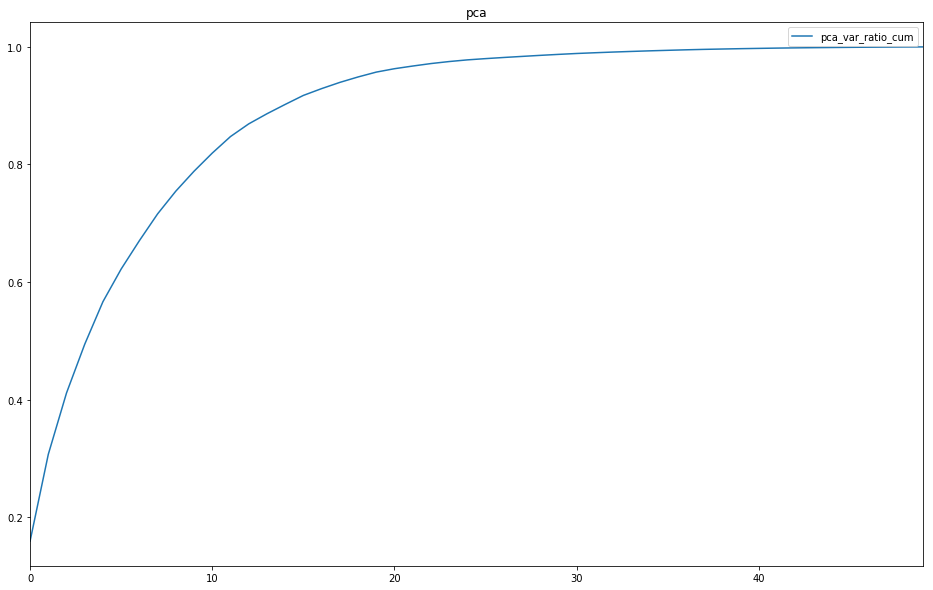

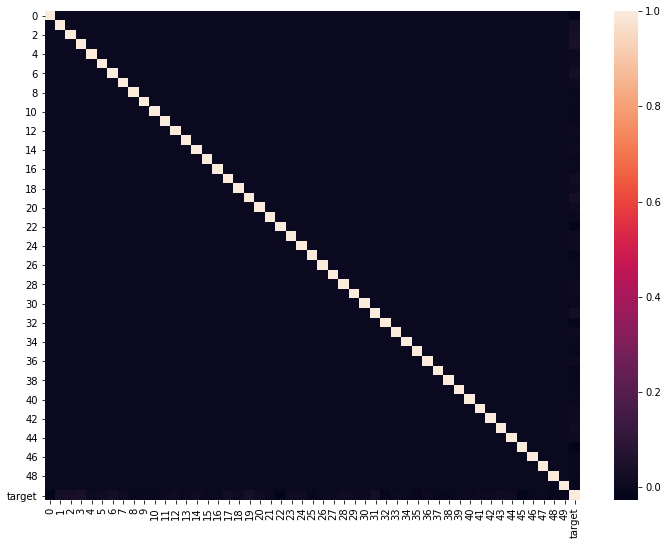

In [3]:
fig = plt.figure(figsize=(12, 9))

pca_cum_var_expl = pd.DataFrame({'pca_var_ratio_cum':dataset.pca.explained_variance_ratio_}).cumsum()
ax = pca_cum_var_expl.plot(title='pca')

fig = plt.figure(figsize=(12, 9))

df = pd.DataFrame(X_data)
df['target'] = y_data
sns.heatmap(df.corr());

abs(df.corr()['target']).sort_values(ascending=False).head(10)

The dataset has zero correlation and we choose to keep every PCA component. Below you'll see the 'blob' plot of the top three components (ranked by abs correlation) with no obvious plane of seperation. This is a visual to showcase the high noise, low signal nature of this dataset.

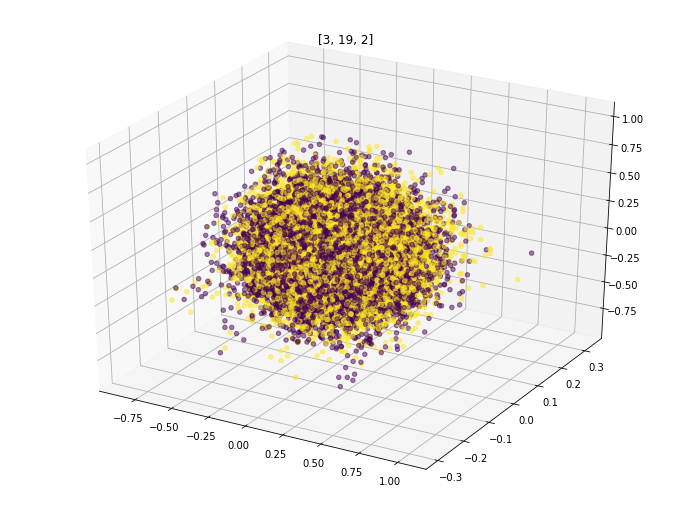

In [4]:
most_corr_components = abs(df.corr()['target']).sort_values(ascending=False).head(10).index[1:].tolist()

fig = plt.figure(figsize=(12, 9))
ax = plt.axes(projection='3d')
ax.scatter(X_data[:, most_corr_components[0]], 
           X_data[:, most_corr_components[1]], 
           X_data[:,most_corr_components[2]], c=y_data, alpha=.5,
          );
ax.set_title(str(most_corr_components[0:3]));

### MODEL

A simple Bayesian logistic regression

In [5]:
D = X_data.shape[1]

X = tf.placeholder(tf.float32, [None , D])
w = Normal(loc=tf.zeros(D), scale=tf.ones(D)*10)
b = Normal(loc=tf.zeros(1), scale=tf.ones(1)*10)
y = Bernoulli(logits=(ed.dot(X, w)+b))

### INFERENCE

We use KLqp Variation Inference with batch learning

384/384 [100%] ██████████████████████████████ Elapsed: 8s | Loss: 17186.705


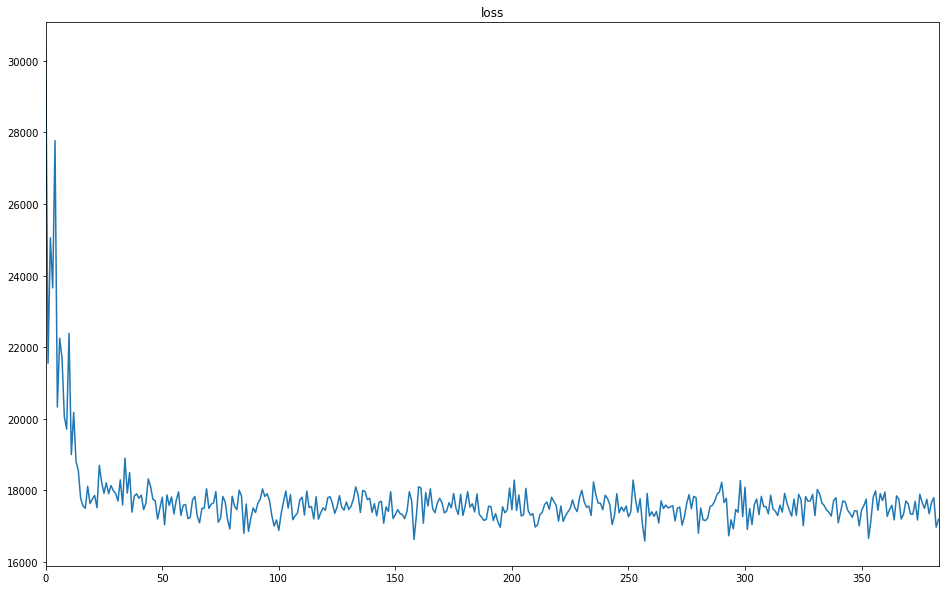

In [6]:
qw = Normal(loc=tf.Variable(tf.random_normal([D])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([D]))))
qb = Normal(loc=tf.Variable(tf.random_normal([1])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

M = 128    # batch size during training
data = generator([X_data, y_data], M)    
y_ph = tf.placeholder(tf.int32, [None])

N = len(X_data)
n_batch = M
n_epoch = 3

inference = ed.KLqp({w: qw, b: qb}, data={y: y_ph})
inference.initialize(n_iter=n_batch * n_epoch, n_samples=5, scale={y: N / M})
tf.global_variables_initializer().run()

info_dicts = []
for _ in range(inference.n_iter):
  X_batch, y_batch = next(data)
  info_dict = inference.update({X: X_batch, y_ph: y_batch})
  inference.print_progress(info_dict)
  info_dicts.append(info_dict)
pd.Series([x['loss'] for x in info_dicts]).plot(title='loss');

Although the logistic regression is our main focus model for this notebook, we'll also train an complementary Bayesian 2-layer neural network model, in order to allow for more interactions terms. We'll revisit this later on after our main criticism.

Our inference technique here is Importance Weighted Varitional Inference (IWVI). The helper functions to maximize the Evidence Lower bound is tweaked slightly, such that we've moved "log" outside of usual terms compared to a standard VAE.

$$ log(p(x)) >= ELBO = -E_{q(z^1; \lambda), ..., q(z^K; \lambda)} [ \log \frac{1}{K} \sum_{k=1}^K \frac{p(x, z^k)}{q(z^k; \lambda)} ]$$

In [7]:
# def neural_network(X):
#     h = tf.tanh(tf.matmul(X, W_0) + b_0)
#     h = tf.tanh(tf.matmul(h, W_1) + b_1)
#     h = tf.matmul(h, W_2) + b_2
#     return tf.reshape(h, [-1])


# # MODEL
# with tf.name_scope("model"):
#     W_0 = Normal(loc=tf.zeros([D, 10]), scale=tf.ones([D, 10]), name="W_0")
#     W_1 = Normal(loc=tf.zeros([10, 10]), scale=tf.ones([10, 10]), name="W_1")
#     W_2 = Normal(loc=tf.zeros([10, 1]), scale=tf.ones([10, 1]), name="W_2")
#     b_0 = Normal(loc=tf.zeros(10), scale=tf.ones(10), name="b_0")
#     b_1 = Normal(loc=tf.zeros(10), scale=tf.ones(10), name="b_1")
#     b_2 = Normal(loc=tf.zeros(1), scale=tf.ones(1), name="b_2")

#     y_nn = Bernoulli(logits=neural_network(X))

# # INFERENCE
# with tf.name_scope("posterior"):
#     with tf.name_scope("qW_0"):
#         qW_0 = Normal(loc=tf.Variable(tf.random_normal([D, 10]), name="loc"),
#                   scale=tf.nn.softplus(
#                       tf.Variable(tf.random_normal([D, 10]), name="scale")))
#     with tf.name_scope("qW_1"):
#         qW_1 = Normal(loc=tf.Variable(tf.random_normal([10, 10]), name="loc"),
#                   scale=tf.nn.softplus(
#                       tf.Variable(tf.random_normal([10, 10]), name="scale")))
#     with tf.name_scope("qW_2"):
#         qW_2 = Normal(loc=tf.Variable(tf.random_normal([10, 1]), name="loc"),
#                   scale=tf.nn.softplus(
#                       tf.Variable(tf.random_normal([10, 1]), name="scale")))
#     with tf.name_scope("qb_0"):
#         qb_0 = Normal(loc=tf.Variable(tf.random_normal([10]), name="loc"),
#                   scale=tf.nn.softplus(
#                       tf.Variable(tf.random_normal([10]), name="scale")))
#     with tf.name_scope("qb_1"):
#         qb_1 = Normal(loc=tf.Variable(tf.random_normal([10]), name="loc"),
#                   scale=tf.nn.softplus(
#                       tf.Variable(tf.random_normal([10]), name="scale")))
#     with tf.name_scope("qb_2"):
#         qb_2 = Normal(loc=tf.Variable(tf.random_normal([1]), name="loc"),
#                   scale=tf.nn.softplus(
#                       tf.Variable(tf.random_normal([1]), name="scale")))

# inference = IWVI({W_0: qW_0, b_0: qb_0,
#                   W_1: qW_1, b_1: qb_1,
#                   W_2: qW_2, b_2: qb_2}, data={X: X_data, y_nn: y_data})
# inference.run(K=5, n_iter=100, n_print=1)
# y_nn_post = ed.copy(y, {W_0: qW_0, b_0: qb_0,
#                   W_1: qW_1, b_1: qb_1,
#                   W_2: qW_2, b_2: qb_2})

### CRITICISM

In [8]:
y_post = ed.copy(y, {w: qw, b:qb})

#### todo: implemention of edward's logloss metric is buggy as it accepts predictions instead of logits
#### I've raised an issue here: https://github.com/blei-lab/edward/issues/795

In [10]:
for nom, y_pst in [
#     ('nn',y_nn_post),
                   ('lr',y_post)]:
    for sam,Xx,yy in [("INS", X_data, y_data), ("OOS",X_test, y_test)]:
        print(nom, sam)
        print("binary_acc:", ed.evaluate('binary_accuracy', data={X: Xx, y_pst: yy}))
        print("log_loss:", ed.evaluate('log_loss', data={X: Xx, y_post: yy}))  # todo bug in implementation

lr INS
binary_acc: 0.535006
log_loss: 0.731039
lr OOS
binary_acc: 0.518048
log_loss: 0.740065


In [11]:
print("log_loss:", ed.evaluate('log_loss', data={X: X_data, y_post: y_data})) # todo bug in implementation
print("categorical_crossentropy:", ed.evaluate('categorical_crossentropy', data={X: X_data, y_post: y_data}))
print("log_likelihood:", ed.evaluate('log_likelihood', data={X: X_data, y_post: y_data}))

log_loss: 0.730636
categorical_crossentropy: 127663.0
log_likelihood: -0.690009


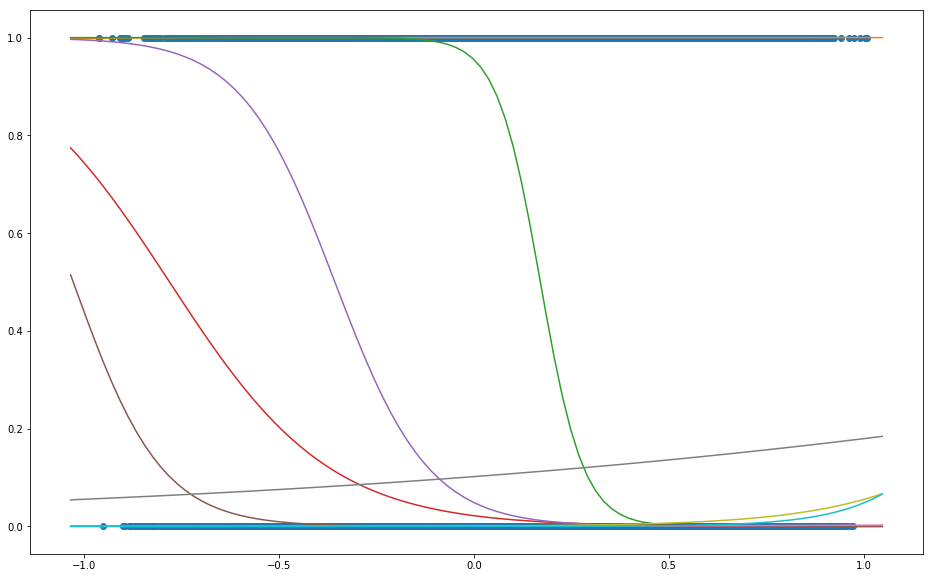

In [12]:
ww = visualise(X_data, y_data, w, b) #prior samples

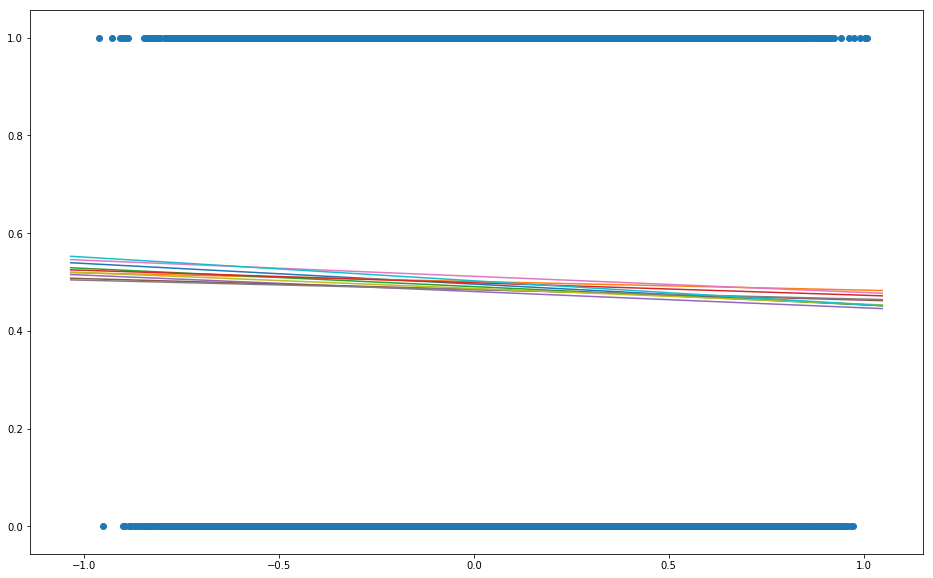

In [13]:
ww = visualise(X_data, y_data, qw, qb) #posterior samples

In [14]:
def binary_crossentropy(y_true, y_pred):
  """Binary cross-entropy.
  Args:
    y_ue: tf.Tensor.
      Tensor of 0s and 1s.
    y_pred: tf.Tensor.
      Tensor of real values (logit probabilities), with same shape as
      `y_true`.
  """
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.cast(y_pred, tf.float32)
  return tf.reduce_mean(
      tf.nn.sigmoid_cross_entropy_with_logits(logits=y_pred, labels=y_true))

In [15]:
from edward.util import check_data, get_session
from sklearn.metrics import log_loss

def get_y_preds(X_data, y_data, qvars, n_samples=10):
    return [[qvar.eval() for _ in range(n_samples)] for qvar in qvars]

def eval_model(Xx, Yy, nom, probabilities=None):
    if probabilities is None:
        ans = get_y_preds(Xx, Yy, qvars=[qw, qb], n_samples=10000)
        zw, zb = [np.mean(an, axis=0) for an in ans]
        probabilities = sigmoid(Xx.dot(zw) + zb)
        
    ins = pd.DataFrame(probabilities, columns=['prob'])
    ins['target'] = Yy
    ins['guess'] = ins['prob'].round().clip(0,1)
    print(nom, '\n------')
    print('acc:', (ins['target'] == ins['guess']).mean())
    print('sk.logloss:', log_loss(ins['target'], ins['prob']))
    sess = get_session()
    print('ed.logloss (corrected):', sess.run(binary_crossentropy(ins['target'], -np.log(1/ins['prob'] -1)   )   ))
    print('ed.logloss (current):', sess.run(binary_crossentropy(ins['target'], ins['prob']   )   ))

    if nom=='ins':
        eras = dataset.training_data['era']
    else:
        eras = dataset.prediction_data['era']
        
    big_ins = pd.concat([pd.DataFrame(Xx), eras, ins], axis=1).dropna()
    consist=0
    for x in big_ins.era.unique():
        lil_ins = big_ins[big_ins.era==x]
        lloss = log_loss(lil_ins['target'], lil_ins['prob'])
        print(x.replace("era","regime"),
              '(%s) :' % str(float(len(lil_ins))/len(big_ins))[:5],
              (lil_ins['target'] == lil_ins['guess']).mean(),
              lloss)
        if lloss < -np.log(.5):
            consist+=1
            
    print('consistency:', float(consist)/len(big_ins.era.unique()))
    print ('')
    return ins

ins = eval_model(X_data, y_data, 'ins')
oos = eval_model(X_test, y_test, 'oos');

ins 
------
acc: 0.535325652104
sk.logloss: 0.688798631673
ed.logloss (corrected): 0.688799
ed.logloss (current): 0.721224
regime1 (0.253) : 0.528539892778 0.690767386674
regime2 (0.252) : 0.539619651347 0.688681453926
regime3 (0.251) : 0.522673031026 0.691288179698
regime4 (0.242) : 0.551040634291 0.684297307901
consistency: 1.0

oos 
------
acc: 0.518748125187
sk.logloss: 0.694379812455
ed.logloss (corrected): 0.69438
ed.logloss (current): 0.722061
regime86 (0.609) : 0.514365457232 0.695538102687
regime87 (0.390) : 0.52557544757 0.692575427338
consistency: 0.5



In [16]:
# see how eval metrics look under sample of maximum uncertainy

from edward.util import check_data, get_session
from sklearn.metrics import log_loss

preds = np.array([.5]*1000)
target = np.random.randint(0,2,1000)

print('acc:', (target == preds.round()).mean())
print('logloss:', log_loss(target, preds))
sess = get_session()
print('ed.logloss:', sess.run(binary_crossentropy(target, preds)))

x = preds
z = target
print('tf.doc.logloss', np.mean(x - x * z + np.log(1 + np.exp(-abs(x)))))

acc: 0.495
logloss: 0.69314718056
ed.logloss: 0.721576
tf.doc.logloss 0.72157698418


In [17]:
ins.describe()

,prob,target,guess
count,24996.000000,24996.00000,24996.000000
mean,0.495470,0.50000,0.459394
std,0.056224,0.50001,0.498358
min,0.281423,0.00000,0.000000
25%,0.456714,0.00000,0.000000
50%,0.493997,0.50000,0.000000
75%,0.532724,1.00000,1.000000
max,0.737852,1.00000,1.000000


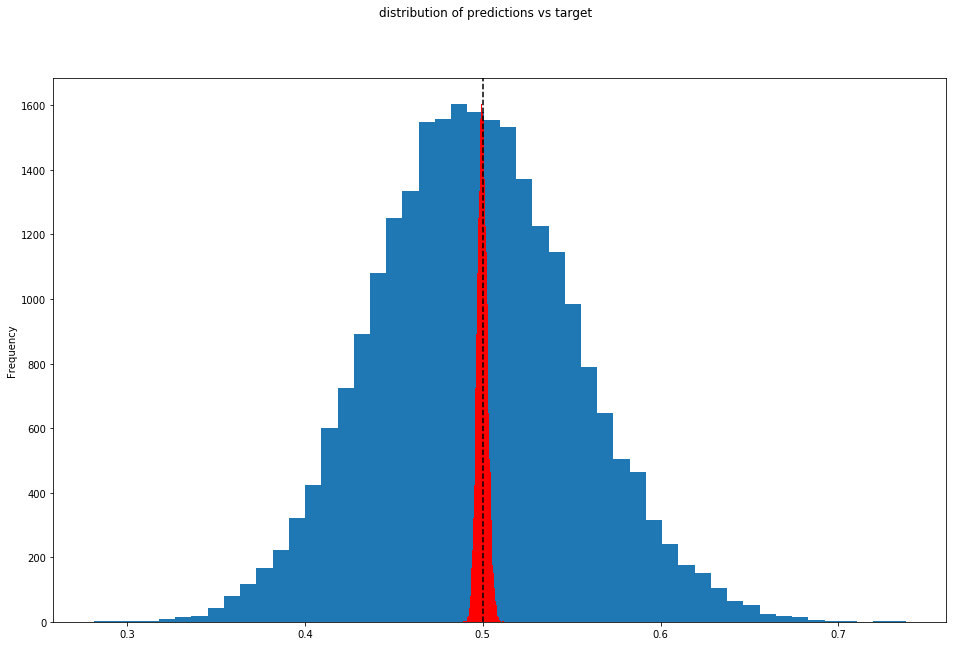

In [18]:
ax = ins['prob'].plot(kind='hist',subplots=True,sharex=False,sharey=True,title='distribution of predictions vs target', bins=50)
ax[0].axvline(.5, color='k', linestyle='--')
#ins['target'].plot(kind='hist', ax=ax[0], color='red', bins=50)

(((ins['prob']-.5)*.05)+.5).plot(kind='hist', ax=ax[0], color='red', bins=50); # strinkage around 50%?

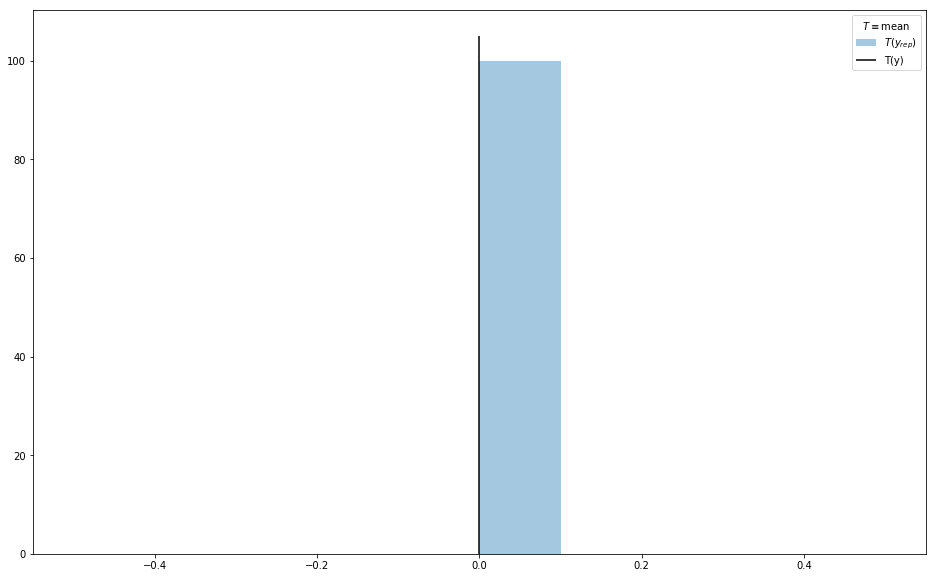

In [19]:
x_post = ed.copy(X, {w: qw, b: qb})

y_rep, y1 = ed.ppc(
    lambda xs, zs: tf.reduce_mean(tf.cast(xs[x_post], tf.float32)),
    data={x_post: X_data})

ed.ppc_stat_hist_plot(
    y1[0], y_rep, stat_name=r'$T \equiv$mean', bins=10)
plt.show()

In [20]:
ed.ppc(lambda xs, zs: tf.reduce_mean(tf.cast(xs[x_post], tf.float32)), data={x_post: X_data})

[array([  3.57112812e-10,   3.57112812e-10,   3.57112812e-10,
          3.57112812e-10,   3.57112812e-10,   3.57112812e-10,
          3.57112812e-10,   3.57112812e-10,   3.57112812e-10,
          3.57112812e-10,   3.57112812e-10,   3.57112812e-10,
          3.57112812e-10,   3.57112812e-10,   3.57112812e-10,
          3.57112812e-10,   3.57112812e-10,   3.57112812e-10,
          3.57112812e-10,   3.57112812e-10,   3.57112812e-10,
          3.57112812e-10,   3.57112812e-10,   3.57112812e-10,
          3.57112812e-10,   3.57112812e-10,   3.57112812e-10,
          3.57112812e-10,   3.57112812e-10,   3.57112812e-10,
          3.57112812e-10,   3.57112812e-10,   3.57112812e-10,
          3.57112812e-10,   3.57112812e-10,   3.57112812e-10,
          3.57112812e-10,   3.57112812e-10,   3.57112812e-10,
          3.57112812e-10,   3.57112812e-10,   3.57112812e-10,
          3.57112812e-10,   3.57112812e-10,   3.57112812e-10,
          3.57112812e-10,   3.57112812e-10,   3.57112812e-10,
        

In [21]:
def T(xs, zs):
    return tf.reduce_max(xs[y_post])

ppc_max = ed.ppc(T, data={X: X_data, y_post: y_data})

In [22]:
## correlation with target is approxmently mean of posterior distribution on parameter

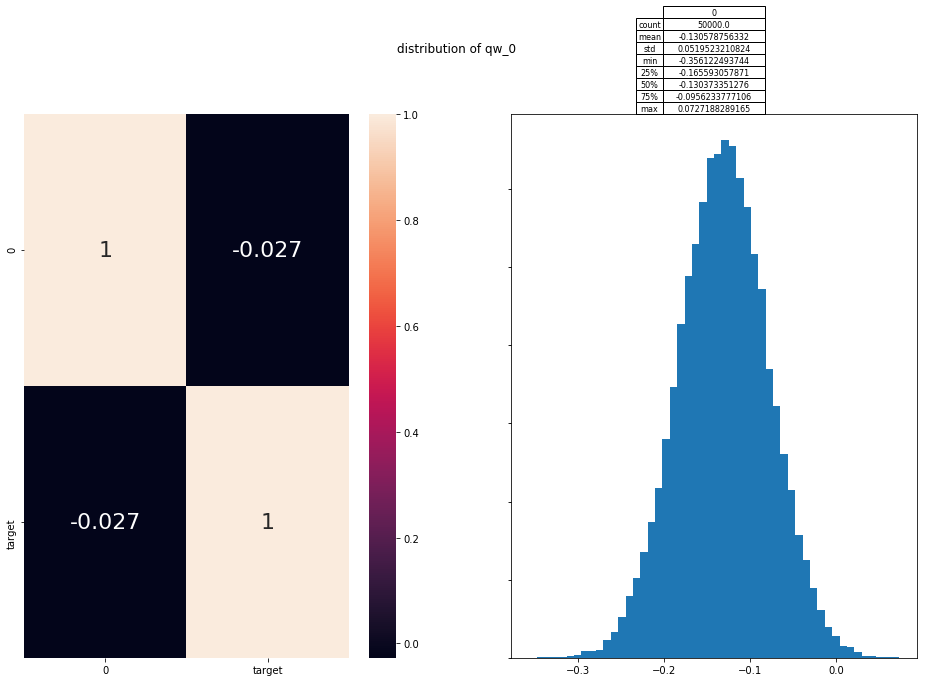

In [23]:
fig, axs = plt.subplots(1,2)


df = pd.DataFrame(X_data[:,0])
df['target'] = y_data
sns.heatmap(df.corr(), annot=True, ax=axs[0], annot_kws={'size':22})
dc = pd.Series(qw.sample(50000).eval()[:,0])
ax = dc.plot(kind='hist',subplots=True,sharex=False,sharey=True,title='distribution of qw_0', bins=50, ax=axs[1])

dcsummary = pd.DataFrame(dc.describe())
plt.table(cellText=dcsummary.values,colWidths = [0.25]*len(dcsummary.columns),
          rowLabels=dcsummary.index,
          colLabels=dcsummary.columns,
          cellLoc = 'center', rowLoc = 'center',
          loc='top');

In [24]:
dcsummary

,0
count,50000.000000
mean,-0.130579
std,0.051952
min,-0.356122
25%,-0.165593
50%,-0.130373
75%,-0.095623
max,0.072719


In [25]:
## ppc is 1 since y_data.mean() > 1?

In [26]:
y_data.mean()

0.5

In [27]:
ppc_max

[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], dtype=int32),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])]

### Criticism (cont.):  Baseline Comparison (sklearn)

We compare our results againist sklearn's Naive Bayes (BernoulliNB) and Logistic Regression (LogisticRegression).

Note how BernoulliNB is somewhat predictive, though strictly the worse of our other candidate models, all the while LogisticRegression does well on the accuracy prediction but poorly on the out of sample logloss metric.

In [28]:
def get_skpreds(dat, shrink=False):
    preds = clf.predict_proba(dat)[:,1]
    if shrink:
        preds -= preds.mean()
        preds *= .3 #todo?
        preds += .5
    return preds

In [29]:
from sklearn.naive_bayes import BernoulliNB

print('NAIVE BAYES:')
clf = BernoulliNB()
clf.fit(X_data, y_data)
preds = get_skpreds(X_data)
eval_model(X_data, y_data, 'ins', preds)
preds = get_skpreds(X_test)
eval_model(X_test, y_test, 'oos', preds);

print('LOGISTIC REGRESSION:')
from sklearn import linear_model
#regularization_C = 1e3 #lower == more regularization
clf = linear_model.LogisticRegression()
clf.fit(X_data, y_data)
preds = get_skpreds(X_data)
eval_model(X_data, y_data, 'ins', preds)
preds = get_skpreds(X_test)
eval_model(X_test, y_test, 'oos', preds);

print('bayesian-forecast')
print('--------')
ins = eval_model(X_data, y_data, 'ins')
oos = eval_model(X_test, y_test, 'oos');

NAIVE BAYES:
ins 
------
acc: 0.533925428068
sk.logloss: 0.68949784753
ed.logloss (corrected): 0.689498
ed.logloss (current): 0.722479
regime1 (0.253) : 0.532008830022 0.690117127231
regime2 (0.252) : 0.530903328051 0.689142422587
regime3 (0.251) : 0.529355608592 0.690419165717
regime4 (0.242) : 0.543937892303 0.688289521737
consistency: 1.0

oos 
------
acc: 0.509349065093
sk.logloss: 0.694645291126
ed.logloss (corrected): 0.694646
ed.logloss (current): 0.723287
regime86 (0.609) : 0.510589394188 0.694829773501
regime87 (0.390) : 0.507416879795 0.694357904388
consistency: 0.0

LOGISTIC REGRESSION:
ins 
------
acc: 0.542606817091
sk.logloss: 0.687249823914
ed.logloss (corrected): 0.68725
ed.logloss (current): 0.721611
regime1 (0.253) : 0.539577420372 0.688006530627
regime2 (0.252) : 0.548177496038 0.686056126112
regime3 (0.251) : 0.532856006364 0.688998190951
regime4 (0.242) : 0.550049554014 0.68588574821
consistency: 1.0

oos 
------
acc: 0.515148485151
sk.logloss: 0.693827511313
ed.lo

Note the subtle difference in OoS in consistency, accurary, and logloss: the edward bayesian probabilistic programming approach actually out performs the sklearn run. Of course at the risk of cherry picking, I'd suggest more empirical trials.

$$ D_{KL}[P(X) \, \Vert \, Q(X)] = \sum_{x \in X} P(x) \, \log \left( \frac{P(x)}{Q(x)} \right) $$

Lets try to explain why theoritically. Our inference technique used was KLqp (reverse KL), which we know makes candidate distribution q 'mode seeking' as opposed to 'mean seeking' in forward KL. Assuming the 'truth' P is a complex function, its not far fetch to think that our model in edward saught one of those modes for our posterior normal distribution of weights, qw.

See an excellent and intuitive write up on forward vs reverse KL divergence here: https://wiseodd.github.io/techblog/2016/12/21/forward-reverse-kl/

![alt text](https://wiseodd.github.io/img/2016-12-21-forward-reverse-kl/forward_kl_bad.png "mode seeking KL")

We also note the distribution of predictions has wider tails in Edward (ie more confidence) yet it can still achieve this result. Remarkable.

,edward,sklearn
count,10001.000000,10001.000000
mean,0.495546,0.500205
std,0.055634,0.051112
min,0.304531,0.314978
25%,0.457725,0.464905
50%,0.495936,0.500535
75%,0.533484,0.535711
max,0.727190,0.685199


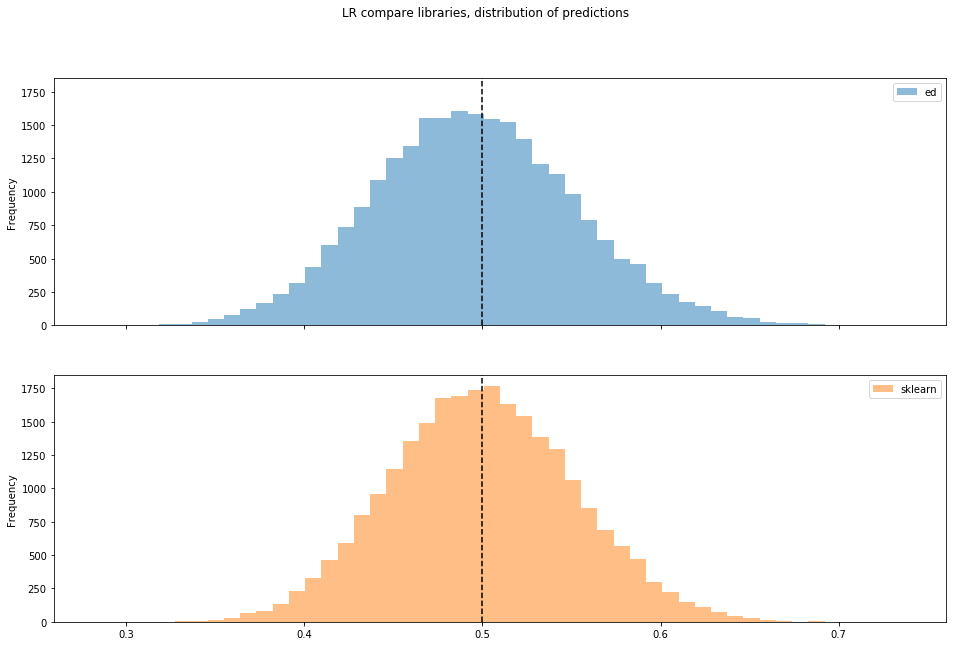

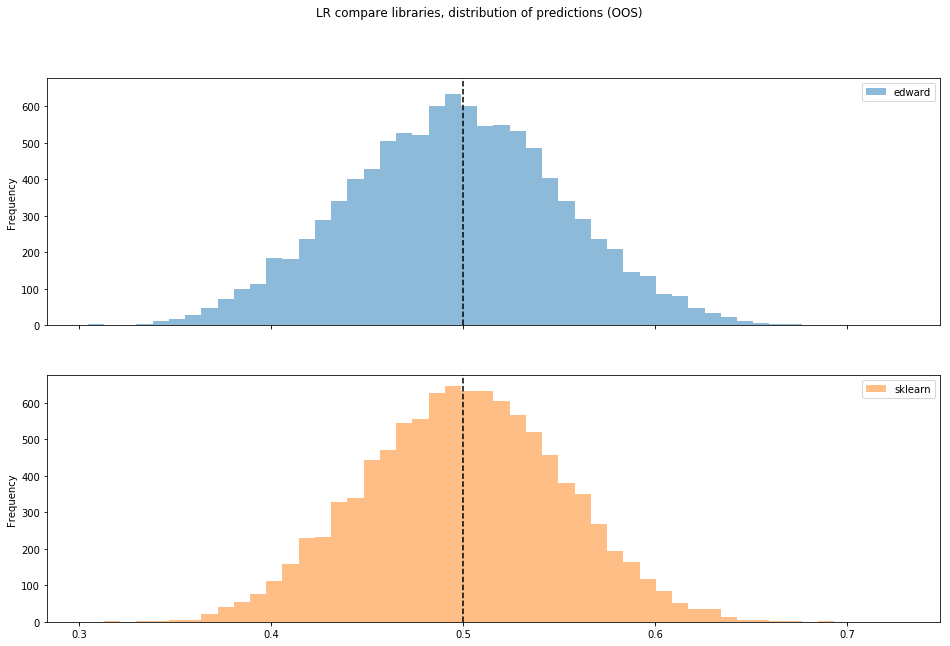

In [30]:
inspreds = pd.DataFrame(
    {
        'sklearn':get_skpreds(X_data),
        'ed':ins['prob']
    })

ax = inspreds.plot(alpha=.5,kind='hist',subplots=True,sharex=True,sharey=True,title='LR compare libraries, distribution of predictions', bins=50)
ax[0].axvline(.5, color='k', linestyle='--')
ax[1].axvline(.5, color='k', linestyle='--')

oospreds = pd.DataFrame(
    {
        'sklearn':get_skpreds(X_test),
        'edward':oos['prob'],
    })
ax = oospreds.plot(alpha=.5,kind='hist',subplots=True,sharex=True,sharey=True,title='LR compare libraries, distribution of predictions (OOS)', bins=50)
ax[0].axvline(.5, color='k', linestyle='--')
ax[1].axvline(.5, color='k', linestyle='--')

oospreds.describe()

We now will use Bayesian Model Averaging(BMA) to come up with an ensemble of our candidate models based on the posterior predictive. The following is a weighted average of predictions, where each weight for model $m$:

$$weight_m = \exp{(\frac{1}{2}BIC_m)}$$

s.t. $BIC_m = 2 \mathcal{L} + k\log(n) $

and $\mathcal{L}$ is the negative log likelihood

In [31]:
nn_w = np.exp((2*ed.evaluate("log_lik", data={X:X_data, y_nn_post:y_data}))*.5)
lr_w = np.exp((2*ed.evaluate("log_lik", data={X:X_data, y_post:y_data}))*.5)

nn_w /= lr_w+nn_w
lr_w /= lr_w+nn_w

print("( %.5f * nn_preds + %.5f * lr_preds)/(%.5f)" % (nn_w,lr_w))

NameError: name 'y_nn_post' is not defined

In [ ]:
# # build posterior predictive after inference:
# # it is parameterized by a posterior sample
# x_post = ed.copy(x, {z: qz, beta: qbeta})

# # posterior predictive check
# # T is a user-defined function of data, T(data)
# T = lambda xs, zs: tf.reduce_mean(xs[x_post])
# ed.ppc(T, data={x_post: x_train})

# # in general T is a discrepancy function of the data (both response and
# # covariates) and latent variables, T(data, latent_vars)
# T = lambda xs, zs: tf.reduce_mean(zs[z])
# ed.ppc(T, data={y_post: y_train, x_ph: x_train},
#        latent_vars={z: qz, beta: qbeta})

# # prior predictive check
# # run ppc on original x
# ed.ppc(T, data={x: x_train})